### Quickstart guide: how to generate high quality questions

In this notebook, we will walk through the process of generatin a high quality hard question for the data science benchmark.
We will cover the following parts:
 1. Finding the right studies: papers, reports, or otherwise human curated text
 2. Fetching datasets used in the studies
 3. Identify one or more interesting questions
 4. Manually solving the pipeline to verify its feasibility
 5. Identifying subtasks and tagging the question with the right metadata

#### 1. High quality studies

For step 1, our aim is to find diverse high quality studies. The ideal study is a paper or report where the authors have clear data pipelines in place to report interesting findings or insights.
For this example, we identified a set of yearly document from the Massachusetts Department of Public Health that report the results of beach testing and water pollution.
The reports for the years 2010-2023 can be found [here (accessed Apr 8., 2025)](https://www.mass.gov/lists/water-quality-at-massachusetts-swimming-beaches#2023-).

The cell below shows an excerpt of the 2023 report.

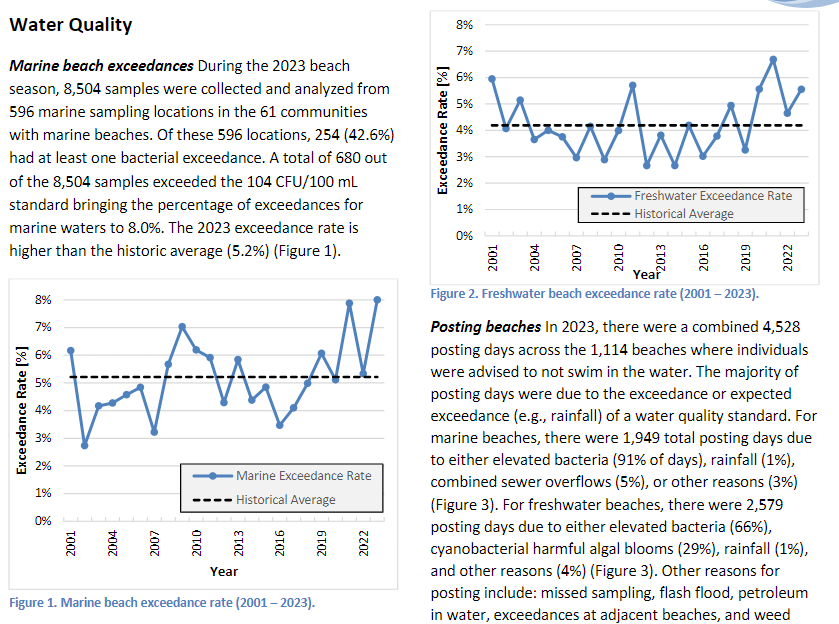

In [2]:
from IPython.display import Image, display
display(Image("screen1.png"))

This report has good properties:
 - It is a yearly report, so it is likely to be updated every year, so there will be new data every year
 - They provide the data used for the analysis and describe (with certain level of detail) the sources and methods used
 - There are plenty of visualizations and insights that we can use to write interesting data science pipelines

### 2. Fetching datasets
This step might be the most human-intensive, because it is highly dependent on the studies used.
It is important to understand which data was used in the report and where to find it.
Often, reports contain sections named "Methods", "Data Sources", "Data Availability", that describe the data used.
For example, in the "References" section of the water quality report there are links to the websites that contain some of the data used.

Other times, the data is available in dashboards or other online tools that are found in the same webpages as the reports.

This step is sensitive; don't give up looking for data if the study mentions it is publicly available.
At the same time, if you can't seem to find any data anywhere, we sadly might have to move on and drop the study.

Sometimes, the data is not of easy access: you might have to manually scrape web dashboards and online tools to get the data.

A little manual scraping is fine, but if you find yourself spending too much time (more than 1/2 hours) on this step, maybe reach out to the team and if the data is very valuable we can think about coding a simple scraper.

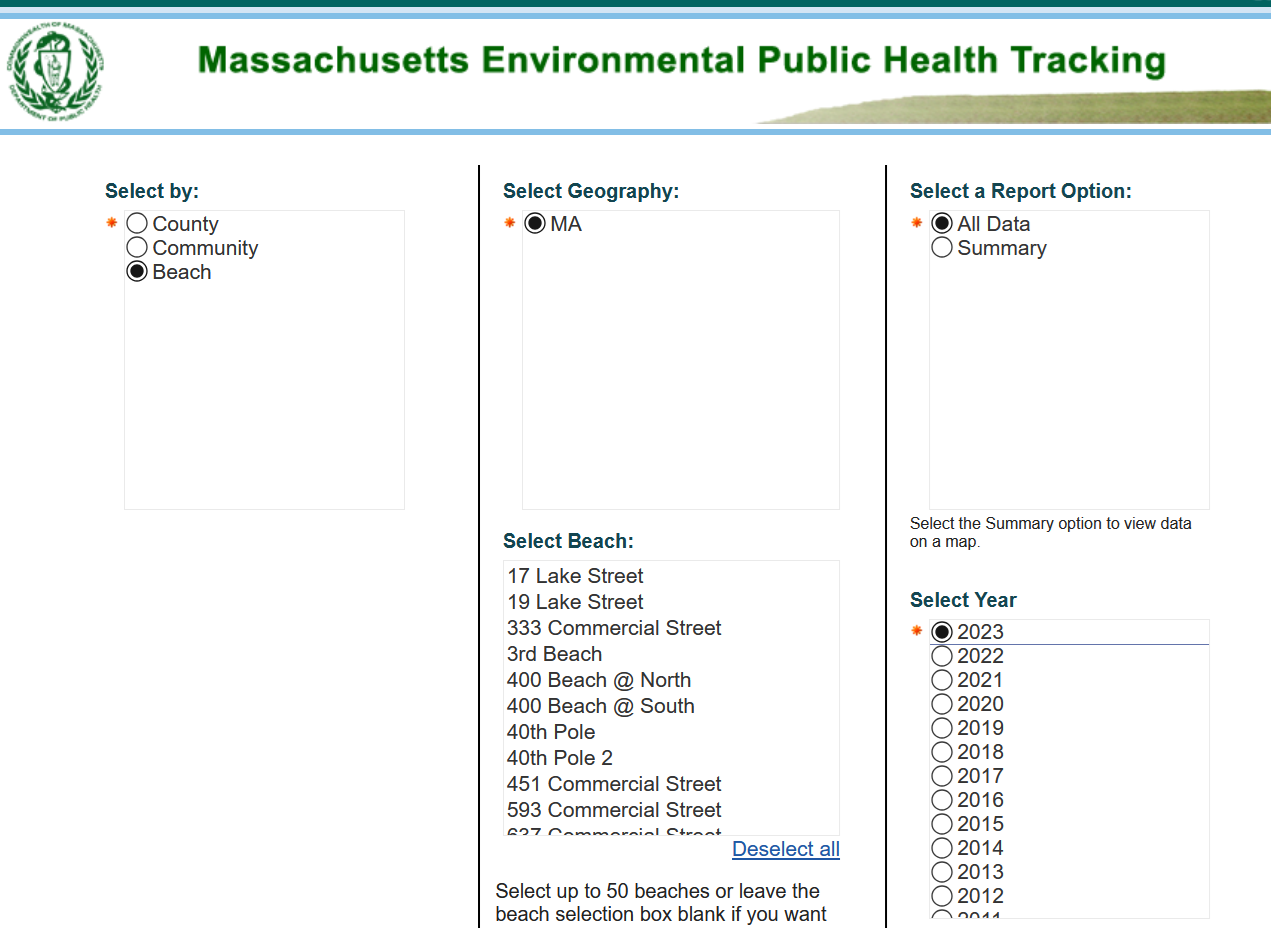

In [4]:
display(Image("screen2.png"))

Once we have the data, we can start looking for interesting questions.
In our case, we assembled the following dataset:

In [22]:
import os
data_path = "../data/environment/"
files = [f for f in os.listdir(data_path) if os.path.isfile(data_path+f)]
print("\n".join(files[:5]),"\n...")

water-body-testing-2020.csv
water-body-testing-2023.csv
water-body-testing-2007.csv
monthly_precipitations_amherst.csv
water-body-testing-2021.csv 
...


Let's see the content of a sample file from the dataset:

In [23]:
import pandas as pd
pd.read_csv(data_path+files[0]).head(3)

,Community Code,Community,County Code,County Description,Year,Sample Date,Beach Name,Beach Type Description,Organism,Indicator Level,Violation
0,242,Provincetown,1,Barnstable,2020,2020-08-03 00:00:00,333 Commercial Street,Marine,Enterococci,5.0,No
1,242,Provincetown,1,Barnstable,2020,2020-07-13 00:00:00,333 Commercial Street,Marine,Enterococci,10.0,No
2,242,Provincetown,1,Barnstable,2020,2020-06-22 00:00:00,333 Commercial Street,Marine,Enterococci,10.0,No


As you can see, the table contains information about:
 - A beach location and its type (Marine or Freshwater)
 - A sample date with the result of the sample (Organism counts)
 - Whether the sample is considered a violation of pollution standards ("Violation" column)

### 3. Identify one or more interesting questions
The next step is to identify one or more interesting questions that can be answered using the data and methods described in the report.
For every study (the report(s) in our case), we want to identify three different classes of questions:
 - **Easy**, for example questions that require a single data source and straightforward pipelines
 - **Hard**, for example questions that require multiple data sources with different schemas or modalities, therefore requiring sophisticated data integration pipelines 

NOTE: These definitions serve as guidelines but we leave the ultimate classification of ``easy`` and ``hard`` to your judgement.

#### Easy question
Based on the report and the data we collected, we can ask the following easy question:
 - In 2018, how many bacterial exceedances were observed in freshwater beaches?

We formulated this question by using terminology from the reports themselves, simulating a domain expert query.
This question can be considered easy because it only requires a single data source (the beach pollution table from 2018), and a simple pipeline to filter the data by beach type, and counting the number of violation.
It is still not obvious since the name of the columns and their values might not match the ones in the question.


### 4. Manually solving the pipeline to verify its feasibility
Let's focus on the easy question we just formulated.
In step 4, we will manually solve the pipeline to verify its feasibility. Although it might seem unnecessary, this step is crucial to ensure that the question is answerable from the data we collected, and also to obtain a repeatable result.

Unfortunately, sometimes the results of reports might be hard to reproduce due to unreported data cleaning or processing steps.
Do not fear! We are only using the reports as inspiration: it is perfectly fine to stick with the answers we obtain from the data we collected, even if they do not match the ones in the report.

In [38]:
import pandas as pd

data_path = "../data/environment/"

year = 2018
input_file = f'water-body-testing-{year}.csv'
df = pd.read_csv(data_path+input_file)

# Filter for freshwater beaches
beach_type = 'Fresh'
fresh = df[df['Beach Type Description'] == beach_type].copy()

# set the violation column to lower case
fresh['Violation'] = fresh['Violation'].str.lower()
exceedance = fresh[fresh['Violation'] == 'yes']
num_exceedance = len(exceedance)

print("Number of exceedances in 2018 freshwater beaches:", num_exceedance)

Number of exceedances in 2018 freshwater beaches: 375


As you can see from the snippet of code above, there are some steps which require knowledge of the data.
First, when filtering for freshwater beaches, we need to know the values of the "Beach Type" column.
The right value for freshwater beaches is "Fresh".

Second, we need to normalize the values of the "Violation" column to lowercase, to be sure all exceedances are counted in the last step.

### 5. Identifying subtasks and generating the question with the right metadata

In solving the pipeline, we implicitly identified three subtasks, which we can use for finer-grained benchmark evaluation:
 - **End-to-end question**: In 2018, how many bacterial exceedances were observed in freshwater beaches?
 - **Subtask 1**: What file contains water quality sample data for 2018?
 - **Subtask 2**: What beaches are freshwater beaches?
 - **Subtask 3**: How many bacterial exceedances are sampled?


To run our benchmark, you will need to generate a JSON file with the following format:

```json
    {
        "id": "unique_question_id",
        "query": "natural language query",
        "answer": "target answer",
        "answer_type": "the type of answer we expect, which dictates the evaluation metric to be used",
        "data_sources": [
            "water-body-testing-2018.csv"
        ],
        ],
        "subtasks": [
            {...}
            ]
    },
```

Here is a quick summary of the format:
 - `id`: a unique identifier for the question. For convention, we use the following format: `{study-tag}-{difficulty}-{number}`.
    For example, in our water quality use case the study tag will be "environment". The first easy question has the id `environment-easy-1`.
 - `query`: the natural language question we want to ask
 - `answer`: the expected answer to the question
 - `answer_type`: The type of answer we expect. Based on the type of answer, a different metric to evaluate the output of the SUT will be used. (see table below)
 - `data_sources`: a list of filenames for the data used to answer the question
 - `subtasks`: a list of subtasks that can be used for evaluation. Every subtask has the same format as the main question, but with one caveat: the format of the id uses the following convention: {study-tag}-{difficulty}-{number}-{subtask-number}.
    For example, the first subtask of the easy question will have the id `environment-easy-1-1`.


    Consider changing the values in the _answer_type_ field to e.g., "exact answer", "string answer", "list answer", etc. etc.

   | Answer Type | Description | Metric |
   | ----------- | ----------- | ------ |
   | `numeric_approximate`    | The answer is numeric and error can be measured in terms of how close the prediction is to the target answer (e.g., "42") | Mean Absolute Error, Mean Squared Error |
   | `string_approximate`    | The answer is a string and the error can be measured with string approximate similarities (e.g., "walt disney" and "disney inc.") | ROUGE, BLUE |
   | `exact`   | The answer must be exact and no other value is allowed (e.g., "true") | Accuracy |
   | `list`      | The answer is a list of values (e.g., ["usa", "canada", "mexico"]) and the prediction could contain all, some, or none of the target values| Precision, Recall, F1 |


Let's generate the JSON file for the easy question we just formulated!

In [ ]:
query_id = "environment-easy-1"
query = "In 2018, how many bacterial exceedances were observed in freshwater beaches?"
answer = num_exceedance
answer_type = "approimate_number"
data_sources = [input_file]

# Subtask 1
subtask1_id = "environment-easy-1-1"
query = "What file contains water quality sample data for 2018?"
answer = input_file
answer_type = "approximate_string"
data_sources = [input_file]
# Subtask 2
subtask2_id = "environment-easy-1-2"
query = "What beaches are freshwater beaches?"
answer = fresh['Beach Name'].unique().tolist()
answer_type = "list"
data_sources = [input_file]

# Subtask 3
subtask3_id = "environment-easy-1-3"
query = "How many bacterial exceedances are sampled from freshwater beaches?"
answer = len(fresh)
answer_type = "approximate_number"
data_sources = [input_file]

benchmark_question = {
    "id": query_id,
    "query": query,
    "answer": answer,
    "answer_type": answer_type,
    "data_sources": data_sources,
    "subtasks": [
        {
            "id": subtask1_id,
            "query": subtask1_id,
            "answer": answer,
            "answer_type": answer_type,
            "data_sources": data_sources
        },
        {
            "id": subtask2_id,
            "query": subtask2_id,
            "answer": answer,
            "answer_type": answer_type,
            "data_sources": data_sources
        },
        {
            "id": subtask3_id,
            "query": subtask3_id,
            "answer": answer,
            "answer_type": answer_type,
            "data_sources": data_sources
        }
    ]
}

NameError: name 'num_exceedance' is not defined

Let's save the question in a JSON file and display it.

In [42]:
import json
with open("environment-easy.json", "w") as f:
    json.dump(benchmark_question, f, indent=4)
print(json.dumps(benchmark_question, indent=2))

{
  "id": "environment-easy-1",
  "query": "How many bacterial exceedances are sampled?",
  "answer": 7641,
  "answer_type": "number",
  "data_sources": [
    "water-body-testing-2018.csv"
  ],
  "subtasks": [
    {
      "id": "environment-easy-1-1",
      "query": "environment-easy-1-1",
      "answer": 7641,
      "answer_type": "number",
      "data_sources": [
        "water-body-testing-2018.csv"
      ]
    },
    {
      "id": "environment-easy-1-2",
      "query": "environment-easy-1-2",
      "answer": 7641,
      "answer_type": "number",
      "data_sources": [
        "water-body-testing-2018.csv"
      ]
    },
    {
      "id": "environment-easy-1-3",
      "query": "environment-easy-1-3",
      "answer": 7641,
      "answer_type": "number",
      "data_sources": [
        "water-body-testing-2018.csv"
      ]
    }
  ]
}


### Hard questions
The process for hard questions is similar to the one we just described.
The main difference is that hard questions may require multiple data sources, and therefore require more complex pipelines.

We will not go through the entire process of generating hard questions, but here are examples of questions that can be generated from the data we collected.

 - **Question**: For the freshwater beaches, what is the difference between the percentage exceedance rate in 2023 and the historic average from 2002 to 2022?
 
  Notice how, for this question, we are using data sources that have the same schema (the beach pollution tables) but we are aggregating the data over multiple years. Then we are asking to aggregate the data over the years to get the average and compare it to the data. This question is inspired by one of the figures in the report.

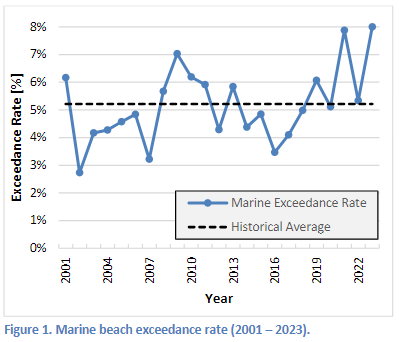

In [44]:
display(Image("medium.png"))

 - **Question**: For the marine beaches, what is the Pearson product-moment correlation from 2002 to 2023 between the rainfall amount in inches during the months June, July, August, and September and the percentage exceedence rate?

This question is hard because it requires multiple data sources with different schemas (the rainfall data and the beach pollution tables). It also requires a more complex pipeline, because of data quality issues in the rainfall data.
Namely, this data contains missing values and aggregated rows that have to be handled correctly in order to compute the correlation between the two variables. 
This question is inspired by one of the figures in the report.

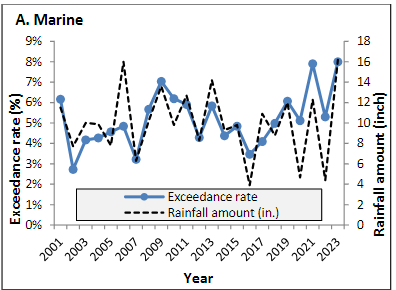

In [45]:
display(Image("hard.png"))

### Conclusion

In this notebook, we walked through the process of generating high quality questions for the data science benchmark.
We covered the following steps:
 1. Finding the right studies: papers, reports, or otherwise human curated text
 2. Fetching datasets used in the study
 3. Identify one or more interesting questions
 4. Manually solving the pipeline to verify its feasibility
 5. Identifying subtasks and tagging the question with the right metadata
We also provided examples of easy, medium, and hard questions that can be generated from the data we collected.


We hope that we can identify a range of 10 questions per study, with 3 easy, and 7 hard questions. We know this is a lot of work, but we are confident that the questions generated will be of high quality and will be useful for the benchmark!